Team Members
- Yutian Wang(#85994168): Yutian contributed to data cleaning, formatting/standardization, visualization, time-series analysis using linear regression, and k-fold cross-validation.
- Ronin Cunningham(#43949676): Ronin contributed to implementing the PyTorch neural network to further analyze the weather and corn prices.
- Prayus Shrestha(#55823454): Prayus contributed to gathering the data through scraping and various APIs.
- Ebin Tomy(#44912301): Ebin contributed by writing the formal analysis and explaining each step.

# Weather Impacts on US Corn Prices

TO-DO: opening paragraph.  This study focuses on the relationship between weather and corn prices in US...

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from rnn_model import RNNModel
from sklearn.metrics import mean_absolute_error, mean_squared_error
from gru_model import GRUModel
import shap

%matplotlib inline

TO-DO: incorporate Prayus' data scrapping section here

TO-DO: add description for these two data sets. source? meaning of each column? 

### Data Cleaning and Formatting

In [195]:
weather_df = pd.read_csv('../data/weather_data.csv', index_col=0)
weather_df.head()

,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum
0,2000-03-24,12.6,-6.6,5.7,0.0
1,2000-03-25,15.0,-1.0,8.7,0.0
2,2000-03-26,18.7,2.4,11.2,0.0
3,2000-03-27,22.9,1.5,14.8,0.0
4,2000-03-28,22.8,7.2,14.8,0.0


In [196]:
weather_df.index = pd.to_datetime(weather_df["time"])
weather_df.index.name = "date"
weather_df["date"] = pd.to_datetime(weather_df.index)
weather_df = weather_df[["temperature_2m_mean", "precipitation_sum"]]
weather_df.head()

,temperature_2m_mean,precipitation_sum
date,,
2000-03-24,5.7,0.0
2000-03-25,8.7,0.0
2000-03-26,11.2,0.0
2000-03-27,14.8,0.0
2000-03-28,14.8,0.0


In [197]:
oil_df = pd.read_csv("../data/crude_oil.csv", index_col=0)
lumber_df = pd.read_csv("../data/lumber_data.csv", index_col=0)
oat_df = pd.read_csv("../data/oat_data.csv", index_col=0)
wheat_df = pd.read_csv("../data/wheat_data.csv", index_col=0)

In [198]:
corn_df = pd.read_csv("../data/corn_data.csv", index_col = 0)
corn_df.head()

,open,close,high,low
2023-04-20,636.50,626.50,637.25,622.00
2023-04-19,675.75,672.25,680.00,671.00
2023-04-18,676.00,677.50,682.50,669.75
2023-04-17,666.00,676.50,677.00,662.25
2023-04-16,635.00,634.75,635.75,634.00


In [199]:
def clean_commodity_df(df: pd.DataFrame, price_col_name: str = "price") -> pd.DataFrame: 
    """Cleans the Commodity DataFrame"""
    
    # Setting the index to be the date
    df.index = pd.to_datetime(df.index)
    df.index.name = "date"
    
    # Setting price to be the day's midpoint, and dropping unnecessary columns
    df[price_col_name] = (df["high"] + df["low"]) / 2 
    df = df[[price_col_name]]
    df = df.dropna() 

    # Sorting by date
    df = df.sort_index()
    return df

In [200]:
corn_df = clean_commodity_df(df=corn_df, price_col_name="corn_price")
corn_df.head()

,corn_price
date,
2018-04-23,377.750
2018-04-24,379.250
2018-04-25,383.875
2018-04-26,385.500
2018-04-27,387.875


In [201]:
oil_df = clean_commodity_df(df=oil_df, price_col_name="oil_price")
lumber_df = clean_commodity_df(df=lumber_df, price_col_name="lumber_price")
oat_df = clean_commodity_df(df=oat_df, price_col_name="oat_price")
wheat_df = clean_commodity_df(df=wheat_df, price_col_name="wheat_price")

In [202]:
# Merging features
X = pd.concat([oil_df, lumber_df, oat_df, wheat_df, weather_df], axis=1).dropna()
X.head()

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum
date,,,,,,
2018-04-24,68.459999,551.500000,221.250,485.625,20.4,0.0
2018-04-25,67.645001,558.200012,224.375,501.125,21.7,0.0
2018-04-26,68.244999,559.800018,220.875,502.500,23.5,0.0
2018-04-27,68.000000,567.600006,220.875,506.625,21.6,0.0
2018-04-30,68.254997,575.500000,224.625,517.750,15.3,0.0


In [203]:
# Lag variables 
lags = [1, 7, 30, 84, 365] # day, week, month, 84 days = time taken for corn to grow, year

# Creating lags in df
for lag in lags: 
    X[f"temp_lag_{lag}"] = X["temperature_2m_mean"].shift(lag)
    X[f"precip_lag_{lag}"] = X["precipitation_sum"].shift(lag)

X.dropna(inplace=True)
X.head()

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365
date,,,,,,,,,,,,,,,,
2019-10-04,52.694999,364.700012,289.750,406.250,15.3,0.0,14.7,0.0,22.6,0.0,24.7,0.0,25.0,0.0,20.4,0.0
2019-10-07,53.325001,370.600006,284.500,404.875,15.9,0.0,15.3,0.0,22.2,0.0,25.8,0.0,26.8,0.1,21.7,0.0
2019-10-08,52.540001,364.800003,282.750,405.500,15.7,0.0,15.9,0.0,22.5,0.0,25.0,0.0,23.2,0.0,23.5,0.0
2019-10-09,53.025002,364.850006,283.000,412.625,15.0,0.0,15.7,0.0,21.8,0.0,25.4,0.0,27.3,0.0,21.6,0.0
2019-10-10,52.675001,365.850006,287.125,408.750,14.2,0.0,15.0,0.0,17.2,0.0,28.1,0.0,28.4,0.0,15.3,0.0


In [204]:
# Autoregressive 
X = X.merge(corn_df, on="date")
X["AR1_corn_price"] = X["corn_price"].shift(1)
X.drop("corn_price", axis=1, inplace=True)
X.dropna(inplace=True)
X.head(3)

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365,AR1_corn_price
date,,,,,,,,,,,,,,,,,
2019-10-07,53.325001,370.600006,284.50,404.875,15.9,0.0,15.3,0.0,22.2,0.0,25.8,0.0,26.8,0.1,21.7,0.0,386.375
2019-10-08,52.540001,364.800003,282.75,405.500,15.7,0.0,15.9,0.0,22.5,0.0,25.0,0.0,23.2,0.0,23.5,0.0,386.375
2019-10-09,53.025002,364.850006,283.00,412.625,15.0,0.0,15.7,0.0,21.8,0.0,25.4,0.0,27.3,0.0,21.6,0.0,391.250


In [205]:
y = X.join(corn_df, how="inner")["corn_price"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Scaling inputs based on training data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [206]:
mlp = MLPRegressor((100, 100), random_state=123, max_iter=1000000)
mlp.fit(X_train_scaled, y_train)
# mlp.predict(X_test)
# mlp.predict(X_test)
# mse_nn = mean_squared_error(y_test, mlp.predict(X_test))
# print(mse_nn)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000000, random_state=123)

It's important to consider the time lag between the weather and corn price data. We should account for the fact that weather conditions in a given year may affect the corn harvest and therefore corn prices mse_nnthe following year. So we shift the index of corn_data backwards by 365 days and create a new column called 'shifted_price_date' with the shifted index values, then to merge the two dataframes.

In [207]:
mse_nn = mean_squared_error(y_test, mlp.predict(X_test_scaled))
print(mse_nn)

320.8440379280027


In [208]:
# corn_data['shifted_price_date'] = corn_data.index - pd.DateOffset(years=1)
# corn_data = corn_data.reset_index()
# merged_data = pd.merge(corn_data, weather_data, left_on='shifted_price_date', right_on='weather_date')
# merged_data = merged_data[['corn_price_date', 'avg_price', 'temperature_2m_mean', 'precipitation_sum']]
# merged_data = merged_data.set_index('corn_price_date')
# merged_data.head()

### Data Standardization

As temperature, precipitation, and price are on different scales, we standardize them to make it easier for comparison. Variables that have large values, such as temperature or precipitation, can dominate the analysis if they are not standardized.

In [209]:
# # Standardize the data
# scaler = StandardScaler()
# merged_data_scaled = pd.DataFrame(scaler.fit_transform(merged_data), columns=merged_data.columns, index=merged_data.index)
# merged_data_scaled.head()

### Trial Plotting

In [210]:
# # plot the time-series
# merged_data_scaled.plot(y='avg_price', figsize=(10,5))
# plt.xlabel('Date')
# plt.ylabel('Corn Average Price')
# plt.title('Corn Average Price Overview')

In [211]:
# plt.scatter(merged_data_scaled['temperature_2m_mean'], merged_data_scaled['avg_price'])
# plt.xlabel('Temperature (°C)')
# plt.ylabel('Avg. Corn Price ($/bushel)')
# plt.title('Temperature vs. Avg. Corn Price')
# plt.show()

# plt.scatter(merged_data_scaled['precipitation_sum'], merged_data_scaled['avg_price'])
# plt.xlabel('Precipitation (mm)')
# plt.ylabel('Avg. Corn Price ($/bushel)')
# plt.title('Precipitation vs. Avg. Corn Price')
# plt.show()

# plt.scatter(merged_data_scaled['temperature_2m_mean'], merged_data_scaled['precipitation_sum'])
# plt.xlabel('Temperature (°C)')
# plt.ylabel('Precipitation (mm)')
# plt.title('Temperature vs. Precipitation')
# plt.show()

Based on the plots, there doesn't seem to be a strong correlation between temperature and precipitation with corn prices. It's also possible that the relationship between weather and corn prices is more complex than a simple linear relationship, and may require further analysis to uncover.

In [212]:
# corr_matrix = merged_data_scaled[['avg_price', 'temperature_2m_mean', 'precipitation_sum']].corr()
# print(corr_matrix)

In [213]:
# sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

### Time Series

Using lags of 30 days and 60 days to capture any possible autocorrelation, without overfitting the model or introducing too much noise. 

In [214]:
# # create lagged variables
# merged_data_scaled['temp_lag1'] = merged_data_scaled['temperature_2m_mean'].shift(30)
# merged_data_scaled['temp_lag2'] = merged_data_scaled['temperature_2m_mean'].shift(60)
# merged_data_scaled['precip_lag1'] = merged_data_scaled['precipitation_sum'].shift(30)
# merged_data_scaled['precip_lag2'] = merged_data_scaled['precipitation_sum'].shift(60)
# merged_data_scaled = merged_data_scaled.dropna()

In [215]:
# # Plot the merged data
# fig, axs = plt.subplots(4, figsize=(12, 12))
# axs[0].plot(merged_data_scaled.index, merged_data_scaled['avg_price'], label='Corn Price')
# axs[0].legend()
# axs[1].plot(merged_data_scaled.index, merged_data_scaled['temperature_2m_mean'], label='Temperature')
# axs[1].legend()
# axs[2].plot(merged_data_scaled.index, merged_data_scaled['precipitation_sum'], label='Precipitation')
# axs[2].legend()
# axs[3].plot(merged_data_scaled.index, merged_data_scaled['temp_lag1'], label='Temperature Lag 1')
# axs[3].plot(merged_data_scaled.index, merged_data_scaled['temp_lag2'], label='Temperature Lag 2')
# axs[3].plot(merged_data_scaled.index, merged_data_scaled['precip_lag1'], label='Precipitation Lag 1')
# axs[3].plot(merged_data_scaled.index, merged_data_scaled['precip_lag2'], label='Precipitation Lag 2')
# axs[3].legend()
# plt.show()

### Linear Regression Analysis

In [216]:
# X = merged_data_scaled[['temp_lag1', 'temp_lag2', 'precip_lag1', 'precip_lag2']]
# y = merged_data_scaled['avg_price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)

# print('Coefficients:', lr_model.coef_)
# print('Intercept:', lr_model.intercept_)

In [217]:
# # make predictions on test data
# y_pred = lr_model.predict(X_test)

# train_rmse = np.sqrt(np.mean((lr_model.predict(X_train) - y_train) ** 2))
# test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

# print(f'Train RMSE: {train_rmse}')
# print(f'Test RMSE: {test_rmse}')

TO-DO: add some discussions here

### Cross-Validation

In [218]:
# lr2 = LinearRegression()
# X = merged_data_scaled.drop('avg_price', axis=1)
# y = merged_data_scaled['avg_price']

# mse_scores = -cross_val_score(lr2, X, y, cv=5, scoring='neg_mean_squared_error')

# print(f"Average MSE: {mse_scores.mean():.4f}, Standard deviation: {mse_scores.std():.4f}")

### RNN Regression

TODO: explanation

In [219]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365,AR1_corn_price
0,1.575212,-0.109286,1.529940,0.783218,1.653405,-0.166338,1.717143,-0.153216,1.725187,-0.167264,1.015209,-0.162666,-0.618779,-0.172591,-1.394119,-0.170581,1.386921
1,0.842799,1.106604,1.723358,0.394488,-1.468948,-0.166338,-1.211669,-0.153216,-1.117703,-0.167264,-1.316400,-0.162666,0.542595,-0.172591,1.232580,-0.170581,0.562448
2,-1.503279,-1.010142,-0.729316,-1.176676,1.166013,-0.166338,1.082440,-0.153216,0.679003,-0.167264,0.413743,-0.162666,-1.538828,-0.172591,-2.077675,-0.170581,-1.517357
3,1.257154,0.793831,2.284921,1.696229,0.792854,-0.166338,0.677147,-0.153216,-0.170073,-0.167264,-0.685232,-0.162666,-1.161759,-0.172591,-0.434068,-0.170581,1.400465
4,2.080716,-0.159827,1.479553,1.953888,1.204091,0.346872,1.464791,-0.153216,1.126285,-0.167264,0.591955,-0.162666,-1.591618,-0.172591,-1.854944,-0.170581,1.457179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,-0.874456,-0.839143,-1.014567,-1.174995,-0.265700,-0.166338,-0.454613,-0.153216,-0.958502,-0.167264,-1.123337,-0.162666,-0.641403,-0.172591,-0.157574,5.138386,-1.191462
701,-0.638539,0.455061,-0.417246,-0.274307,-1.613642,-0.166338,-1.303433,-0.153216,-1.853064,-0.167264,-1.524314,-0.162666,0.512429,-0.172591,1.186498,0.983542,-0.130820
702,-0.249063,1.691297,-0.326225,-0.504520,0.084613,-0.166338,-0.056968,-0.153216,0.011872,-0.167264,-0.625828,-0.162666,-1.486039,-0.172591,-0.387986,-0.170581,0.189150
703,-0.316836,0.639463,-0.418871,-0.554932,-0.715014,-0.166338,-0.661083,-0.153216,-0.048777,-0.167264,-0.811465,-0.162666,-0.829938,-0.172591,0.287890,-0.170581,0.030858


In [220]:
y_train

date
2022-07-05    745.500
2022-01-31    632.500
2020-05-20    319.375
2022-04-08    762.875
2022-06-01    738.375
               ...   
2020-02-27    365.875
2021-01-15    532.125
2021-04-14    588.250
2021-03-19    552.250
2021-10-14    514.625
Name: corn_price, Length: 705, dtype: float64

#### Basic RNN model with Adam optimizer and L2 regularization

##### Training

First, we need to set hyperparameters for our RNN model. After experimenting with various different configurations, below are the hyperparameters that I found to be best

In [221]:
# Set hyperparameters
input_size = 17
hidden_size = 64
output_size = 1
num_epochs = 1000
batch_size = 32
learning_rate = 0.001
sequence_length = 1

# Prepare the train dataset
X_train_arr = np.array(X_train_scaled)
y_train_arr = np.array(y_train)

X_train_arr = X_train_arr.reshape(-1, sequence_length, input_size)
y_train_arr = y_train_arr.reshape(-1, sequence_length, output_size)

train_dataset = TensorDataset(torch.tensor(X_train_arr).float(), torch.tensor(y_train_arr).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
rnn_model_instance = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model_instance.parameters(), lr=learning_rate, weight_decay=1e-5)  # Add weight_decay for L2 regularization

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = rnn_model_instance(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/1000], Loss: 299028.8125
Epoch [2/1000], Loss: 293031.8438
Epoch [3/1000], Loss: 451565.3125
Epoch [4/1000], Loss: 159638.0781
Epoch [5/1000], Loss: 611588.8125
Epoch [6/1000], Loss: 454644.1875
Epoch [7/1000], Loss: 393478.0000
Epoch [8/1000], Loss: 412973.7188
Epoch [9/1000], Loss: 275156.3438
Epoch [10/1000], Loss: 347968.7812
Epoch [11/1000], Loss: 108890.8984
Epoch [12/1000], Loss: 342601.7188
Epoch [13/1000], Loss: 139482.1250
Epoch [14/1000], Loss: 537045.3125
Epoch [15/1000], Loss: 286777.7188
Epoch [16/1000], Loss: 319493.9062
Epoch [17/1000], Loss: 424745.5938
Epoch [18/1000], Loss: 91021.9766
Epoch [19/1000], Loss: 393348.1562
Epoch [20/1000], Loss: 121192.6484
Epoch [21/1000], Loss: 350233.2188
Epoch [22/1000], Loss: 510692.2812
Epoch [23/1000], Loss: 140073.4062
Epoch [24/1000], Loss: 161395.1719
Epoch [25/1000], Loss: 110791.5469
Epoch [26/1000], Loss: 112065.9609
Epoch [27/1000], Loss: 148412.0312
Epoch [28/1000], Loss: 340424.2500
Epoch [29/1000], Loss: 117407.

##### Testing

In [222]:
# Prepare the test dataset
X_test_arr = np.array(X_test_scaled)
y_test_arr = np.array(y_test)

X_test_arr = X_test_arr.reshape(-1, sequence_length, input_size)
y_test_arr = y_test_arr.reshape(-1, sequence_length, output_size)

test_dataset = TensorDataset(torch.tensor(X_test_arr).float(), torch.tensor(y_test_arr).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
rnn_model_instance.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = rnn_model_instance(inputs)
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(targets.numpy().flatten())

# Calculate accuracy metrics
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

Mean Absolute Error: 9.1263
Mean Squared Error: 204.6070
Root Mean Squared Error: 14.3041


#### GRU model with Adam optimizer and L2 Regularization

##### Training

In [223]:
# Set hyperparameters

input_size = 17
hidden_size = 64
output_size = 1
num_epochs = 1000
batch_size = 32
learning_rate = 0.001
sequence_length = 1

# Prepare the train dataset
X_train_arr = np.array(X_train_scaled)
y_train_arr = np.array(y_train)

X_train_arr = X_train_arr.reshape(-1, sequence_length, input_size)
y_train_arr = y_train_arr.reshape(-1, sequence_length, output_size)

train_dataset = TensorDataset(torch.tensor(X_train_arr).float(), torch.tensor(y_train_arr).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
gru_model_instance = GRUModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model_instance.parameters(), lr=learning_rate, weight_decay=1e-5)

# Train the modelt
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = gru_model_instance(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/1000], Loss: 104749.7734
Epoch [2/1000], Loss: 328637.4062
Epoch [3/1000], Loss: 159531.5625
Epoch [4/1000], Loss: 588645.5625
Epoch [5/1000], Loss: 456177.1562
Epoch [6/1000], Loss: 568870.6250
Epoch [7/1000], Loss: 580721.5000
Epoch [8/1000], Loss: 340115.6250
Epoch [9/1000], Loss: 133238.1250
Epoch [10/1000], Loss: 421235.8438
Epoch [11/1000], Loss: 413024.8750
Epoch [12/1000], Loss: 421717.4688
Epoch [13/1000], Loss: 142474.8438
Epoch [14/1000], Loss: 469797.3750
Epoch [15/1000], Loss: 307920.1250
Epoch [16/1000], Loss: 175287.6250
Epoch [17/1000], Loss: 593021.6250
Epoch [18/1000], Loss: 532441.8750
Epoch [19/1000], Loss: 130756.0000
Epoch [20/1000], Loss: 522047.7812
Epoch [21/1000], Loss: 269166.6562
Epoch [22/1000], Loss: 353052.9062
Epoch [23/1000], Loss: 549176.4375
Epoch [24/1000], Loss: 87265.7188
Epoch [25/1000], Loss: 294569.8750
Epoch [26/1000], Loss: 123597.3281
Epoch [27/1000], Loss: 104547.9844
Epoch [28/1000], Loss: 280794.6250
Epoch [29/1000], Loss: 144862.

##### Testing

In [224]:
# Prepare the test dataset
X_test_arr = np.array(X_test_scaled)
y_test_arr = np.array(y_test)

X_test_arr = X_test_arr.reshape(-1, sequence_length, input_size)
y_test_arr = y_test_arr.reshape(-1, sequence_length, output_size)

test_dataset = TensorDataset(torch.tensor(X_test_arr).float(), torch.tensor(y_test_arr).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
gru_model_instance.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = gru_model_instance(inputs)
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(targets.numpy().flatten())

# Calculate accuracy metrics
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

Mean Absolute Error: 9.2837
Mean Squared Error: 242.7776
Root Mean Squared Error: 15.5813


### Shapley Values of our Best Model

Permutation explainer: 178it [00:20,  4.93it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


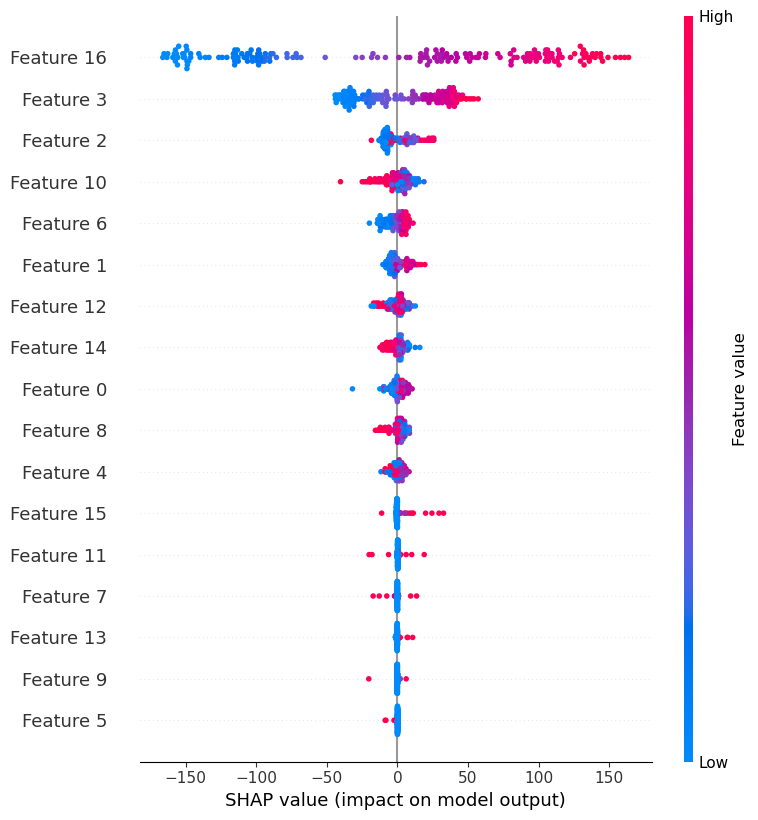

In [225]:
best_model = gru_model_instance

def model_wrapper(x):
    x_tensor = torch.FloatTensor(x).unsqueeze(1)
    with torch.no_grad():
        output = best_model(x_tensor)
    return output.numpy()

# Initialize the explainer
explainer = shap.Explainer(model_wrapper, X_test_scaled)

# Compute SHAP values for X_test
shap_values = explainer(X_test_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)